<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Masterproject_final_tensor_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [51]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torchvision.transforms.functional as TF 

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os
import random
import click
import sklearn
import sklearn.model_selection
from collections import defaultdict
from sklearn.metrics import accuracy_score
from pathlib import Path
import sys
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt
!pip install partitura
import partitura
import statistics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%%capture
!git clone https://github.com/aim56009/AI-MA_project.git

# Dataloader - Set the dataset

In [3]:
#PATH_TO_DATA = "AI-MA_project/bach_pr_fugues"
PATH_TO_DATA = "AI-MA_project/pianoroll_88"

batch_size = 1 
workers = 0

In [4]:
class MusicDataset(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir

        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []

        for iLabel in range(len(labels)):
            
            if iLabel == 4:   
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                        loaded_obj = pickle.load(f)  
                        voice_files.append(loaded_obj) 
                        len_list.append(len(loaded_obj.T))
                        
                self.pr_dict[self.labels[iLabel]] = voice_files 
                self.pr_dict["length"] = len_list
    
            else:
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                for name in file_names:
                    with open(name ,'rb') as f: 
                        loaded_obj = pickle.load(f)     
                        voice_files.append(loaded_obj)

                self.pr_dict[self.labels[iLabel]] = voice_files 


    def __len__(self):
      
        return len(self.pr_dict[self.labels[0]])
  

    def __getitem__(self, idx):          

        out_list = []
        for key, value in self.pr_dict.items():
            out_list.append(self.pr_dict[key][idx])    

        v0 = torch.tensor(out_list[0].T)
        v1 = torch.tensor(out_list[1].T)
        v2 = torch.tensor(out_list[2].T)
        v3 = torch.tensor(out_list[3].T)
        v_all = torch.tensor(out_list[4].T) 
        length = self.pr_dict["length"][idx]


        return (v0, v1, v2, v3, v_all, length)

In [5]:
class MusicDataset_new(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir

        self.name_list = ["1f01","1f02","1f03","1f04","1f05","1f06","1f07","1f08","1f09","1f10","1f11","1f12","1f13","1f14","1f15","1f16","1f17","1f18","1f19","1f20","1f21","1f22","1f23","1f24","2f01","2f02","2f03","2f04","2f05","2f06","2f07","2f08","2f09","2f10","2f11","2f12","2f13","2f14","2f15","2f16","2f17","2f18","2f19","2f20","2f21","2f22","2f23","2f24"]
        self.name_list_voice_3 =  ['1f01', '1f05', '1f12', '1f14', '1f16', '1f17', '1f18', '1f23', '1f24', '2f02', '2f05', '2f07', '2f08', '2f09', '2f16', '2f17',  '2f22', '2f23']
        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []
        nbr_voices_list = []
        file_names_list = []

        for iLabel in range(len(labels)):
            
            if iLabel == 4:   
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                        loaded_obj = pickle.load(f)  
                        voice_files.append(loaded_obj) 
                        len_list.append(len(loaded_obj.T))

                        file_names_list.append(name[-8:-4])

                    if "AI-MA_project/bach_pr_fugues/voice_3/voice_3_" + name[49:53] + ".pkl" in sorted(glob.glob(os.path.join(PATH_TO_DATA, "voice_3", "*.pkl"))):
                        nbr_voices_list.append(4)
                    else:
                        nbr_voices_list.append(3)
                        
                self.pr_dict[self.labels[iLabel]] = voice_files 
                self.pr_dict["length"] = len_list
                self.pr_dict["nbr_voices"] = nbr_voices_list
                self.pr_dict["name"] = file_names_list
                #print(self.pr_dict["name"])


            if iLabel == 3:  
                voice_files = []
                file_names_3 = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                file_names_2 = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[2], "*.pkl")))   
                
                ###### loop over all filnames in voices_2 and if an element there is not present in voices_3: append "missing" to the voice_files of label=3 => important bc. self.pr_dict[voice_3] has then len 42 and otherwise it would only have len 18  .. these "missing" el are not considered later in the dataloader (if len=3 is a diff case of get_idx)
                for name in file_names_2:
                    if name[45:49] in self.name_list_voice_3:
                      correct_name_3 = "AI-MA_project/bach_pr_fugues/voice_3/voice_3_" + name[45:49] + ".pkl"
                      with open(correct_name_3 ,'rb') as f:  
                            loaded_obj = pickle.load(f)  
                            voice_files.append(loaded_obj)
                    else:
                      voice_files.append("missing")

                self.pr_dict[self.labels[iLabel]] = voice_files 
                

                
            else:
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                for name in file_names:
                    with open(name ,'rb') as f: 
                          loaded_obj = pickle.load(f)     
                          voice_files.append(loaded_obj)

                self.pr_dict[self.labels[iLabel]] = voice_files 


    def __len__(self):
        return len(self.pr_dict[self.labels[0]])

    def __getitem__(self, idx):      
        out_list = []
        
        if self.pr_dict["nbr_voices"][idx] == 4:
            for key, value in self.pr_dict.items():
              out_list.append(self.pr_dict[key][idx])
                              
            v0 = torch.tensor(out_list[0].T)
            v1 = torch.tensor(out_list[1].T)
            v2 = torch.tensor(out_list[2].T)
            v3 = torch.tensor(out_list[3].T)
            v_all = torch.tensor(out_list[4].T) 
            length = self.pr_dict["length"][idx]
            nbr_voices = self.pr_dict["nbr_voices"][idx]
            file_name = self.pr_dict["name"][idx]

            voices = torch.stack([v0, v1, v2, v3, v_all], dim=2)
            
            return (voices, length, nbr_voices, file_name)
        
        if self.pr_dict["nbr_voices"][idx] == 3:

            for key, value in self.pr_dict.items():
                if key != "voice_3":
                  out_list.append(self.pr_dict[key][idx]) 
            
            v0 = torch.tensor(out_list[0].T)
            v1 = torch.tensor(out_list[1].T)
            v2 = torch.tensor(out_list[2].T)
            v3 = torch.zeros(v2.shape)
            v_all = torch.tensor(out_list[3].T) 
            length = self.pr_dict["length"][idx]
            nbr_voices = self.pr_dict["nbr_voices"][idx]
            file_name = self.pr_dict["name"][idx]
            
            voices = torch.stack([v0, v1, v2, v3, v_all], dim=2)

            
            return (voices, length, nbr_voices, file_name)
        

In [6]:
class MusicDataset_chor(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir

        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []
        nbr_voices_list = []
        file_names_list = []

        for iLabel in range(len(labels)):
            
            if iLabel == 4:   
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                        loaded_obj = pickle.load(f)  
                        voice_files.append(loaded_obj) 
                        len_list.append(len(loaded_obj.T))
                        file_names_list.append(name[-7:-4])      # e.g. name = AI-MA_project/pianoroll_88/voice_all/voice_all_001.pkl

                        
                self.pr_dict[self.labels[iLabel]] = voice_files 
                self.pr_dict["length"] = len_list
                self.pr_dict["name"] = file_names_list
                #print(self.pr_dict["name"])
              

            else:
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                for name in file_names:
                    with open(name ,'rb') as f: 
                        loaded_obj = pickle.load(f)     
                        voice_files.append(loaded_obj)

                self.pr_dict[self.labels[iLabel]] = voice_files 



    def __len__(self):
        return len(self.pr_dict[self.labels[0]])

    def __getitem__(self, idx):      
        out_list = []
        
        for key, value in self.pr_dict.items():
            out_list.append(self.pr_dict[key][idx])
                            
        v0 = torch.tensor(out_list[0].T)
        v1 = torch.tensor(out_list[1].T)
        v2 = torch.tensor(out_list[2].T)
        v3 = torch.tensor(out_list[3].T)
        v_all = torch.tensor(out_list[4].T) 
        length = self.pr_dict["length"][idx]
        file_name = self.pr_dict["name"][idx]

        voices = torch.stack([v0, v1, v2, v3, v_all], dim=2)
        
        return (voices, length, 4, file_name)     # 4 bc nbr voices is always 4

In [7]:
dataset = MusicDataset_chor(PATH_TO_DATA)
#dataset = MusicDataset_new(PATH_TO_DATA)
loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

In [8]:
"""
for i, sample_batched in enumerate(loader):
    all_voices, length, nbr_voices = sample_batched
    if nbr_voices ==3:
      print(i,nbr_voices,all_voices.shape)
    else:
      print(i,nbr_voices)
"""
for i, sample_batched in enumerate(loader):
    if i == 1:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices)


002 tensor([4])


In [9]:
pianoroll_0 = all_voices.squeeze()[:,:,0].numpy()
pianoroll_1 = all_voices.squeeze()[:,:,1].numpy()
pianoroll_2 = all_voices.squeeze()[:,:,2].numpy()
pianoroll_3 = all_voices.squeeze()[:,:,3].numpy()
pianoroll_all = all_voices.squeeze()[:,:,-1].numpy()

time_unit = "beat"
time_div = 12
piano_range = True

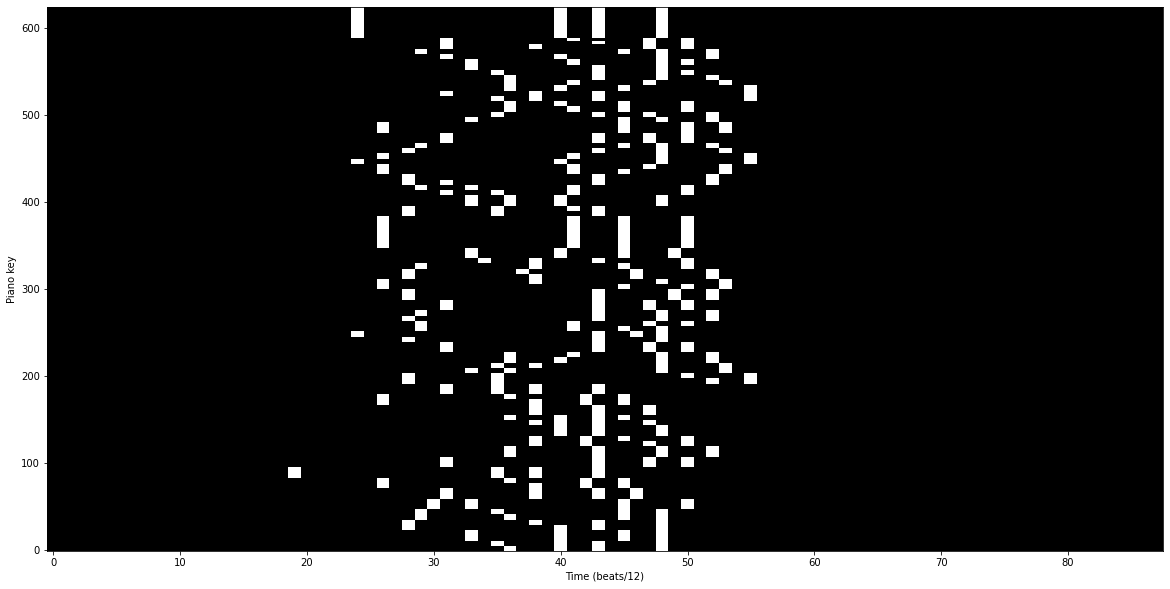

In [10]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(pianoroll_all, origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({time_unit}s/{time_div})')
ax.set_ylabel('Piano key' if piano_range else 'MIDI pitch')
plt.show()

In [11]:
"""
for i, sample_batched in enumerate(loader):
    all_voices, length, nbr_voices = sample_batched
    if nbr_voices ==3:
      print(i,nbr_voices,all_voices.shape)
    else:
      print(i,nbr_voices)

for i, sample_batched in enumerate(loader):
  if i ==10:
    all_voices, length, nbr_voices, _ = sample_batched
    all_voices_pr = all_voices[0,:,:,-1].numpy()
    
    note_array = partitura.utils.pianoroll_to_notearray(all_voices[0,:,:,-1].numpy(), time_div=12, time_unit='beat')
    print(note_array.shape)
    print(note_array[:10])
    print(note_array.dtype.names)

    #print(i,nbr_voices,all_voices.shape)

"""

"\nfor i, sample_batched in enumerate(loader):\n    all_voices, length, nbr_voices = sample_batched\n    if nbr_voices ==3:\n      print(i,nbr_voices,all_voices.shape)\n    else:\n      print(i,nbr_voices)\n\nfor i, sample_batched in enumerate(loader):\n  if i ==10:\n    all_voices, length, nbr_voices, _ = sample_batched\n    all_voices_pr = all_voices[0,:,:,-1].numpy()\n    \n    note_array = partitura.utils.pianoroll_to_notearray(all_voices[0,:,:,-1].numpy(), time_div=12, time_unit='beat')\n    print(note_array.shape)\n    print(note_array[:10])\n    print(note_array.dtype.names)\n\n    #print(i,nbr_voices,all_voices.shape)\n\n"

# Define Music - Model


Define UNET 

In [12]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList([self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList([nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2) for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList([self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 

In [13]:
loss_0 = []
loss_1 = []
loss_2 = []
loss_3 = []
class MusicNetwork(nn.Module):

    def __init__(self, network_type,output_dim=88, hidden_dim=300, rnn_depth=1, cell_type="GRU"):                 
        super(MusicNetwork, self).__init__()

        self.network_type = network_type
        self.n_out = output_dim
        input_dim = output_dim 
        rnn_cell = nn.GRU
        self.rnn = rnn_cell(input_size=input_dim, hidden_size=hidden_dim, num_layers=rnn_depth, batch_first=True)
        self.cnn = UNET(in_channels=1, classes=4)
        self.top_layer_voice_0 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_1 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_2 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_3 = nn.Linear(hidden_dim, self.n_out)
        self.loss = nn.CrossEntropyLoss(reduction="mean")                       # use weight parameters maybe take 1/88       

    

    def compute_outputs(self, sentences, sentences_len):
        if self.network_type == "RNN":
          rnn_out ,_= self.rnn(sentences)     
          out_0 = self.top_layer_voice_0(rnn_out)
          out_1 = self.top_layer_voice_1(rnn_out)
          out_2 = self.top_layer_voice_2(rnn_out)
          out_3 = self.top_layer_voice_3(rnn_out)

          return torch.stack([out_0, out_1, out_2, out_3], dim=1)

        else: 
          sentences = sentences[:,None]
          out = self.cnn(sentences)
          return out                      ### squeeze output here before returning                                       
        

    def forward(self, voices, sentences_len, nbr_voices):            

        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_comb = self.compute_outputs(voices[:,:,:,-1], sentences_len)

        # Flatten the outputs and the labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        score_0  = scores_comb[:,0,:,:].view(-1, self.n_out)
        score_1  = scores_comb[:,1,:,:].view(-1, self.n_out)
        score_2  = scores_comb[:,2,:,:].view(-1, self.n_out)
        score_3  = scores_comb[:,3,:,:].view(-1, self.n_out)


        v0 = voices[:,:,:,0].squeeze()
        v1 = voices[:,:,:,1].squeeze()
        v2 = voices[:,:,:,2].squeeze()
        v3 = voices[:,:,:,3].squeeze()

        #print("nbr_voices",nbr_voices)


        if nbr_voices==4:
            loss = self.loss(score_0, v0) +  self.loss(score_1, v1) +  self.loss(score_2, v2) + 1.5* self.loss(score_3, v3) 
            
            loss_0.append(self.loss(score_0, v0).cpu().detach().numpy())
            loss_1.append(self.loss(score_1, v1).cpu().detach().numpy())
            loss_2.append(self.loss(score_2, v2).cpu().detach().numpy())
            loss_3.append(self.loss(score_3, v3).cpu().detach().numpy())
            print("self.loss(score_0, v0)",self.loss(score_0, v0).cpu().detach().numpy())
            print("self.loss(score_0, v1)",self.loss(score_1, v1).cpu().detach().numpy())
            print("self.loss(score_0, v2)",self.loss(score_2, v2).cpu().detach().numpy())
            print("self.loss(score_2, v3)",self.loss(score_3, v3).cpu().detach().numpy())
            print("loss",loss)      
        else:
            loss = self.loss(score_0, v0) + self.loss(score_1, v1) + self.loss(score_2, v2) 
        
        return loss   #change also to matrix version
        


    def predict(self, sentences, sentences_len,monophonic=True):

        # Compute the outputs from the linear units.

        scores_comb = self.compute_outputs(sentences, sentences_len)

        if monophonic==False:
            sum = scores_comb * sentences[:,None,:,:]
            return np.squeeze(sum.cpu().numpy())
            

        else:
            # Select the top-scoring labels. The shape is now (max_len, n_sentences).
            #predicted = scores_comb.argmax(dim=3)
            #return np.squeeze(predicted.cpu().numpy())

            sum_tensor = scores_comb * sentences[:,None,:,:]
            prediction = np.squeeze(sum_tensor.cpu().numpy())                # prediction is of shape 4,T,88 and contains a probability for the result to belong to one of the 4 voices -> taking argmax: gives the voice with the highes probability
            v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
            
            mask_pred = np.squeeze(sentences)== 0
            v_pred_argm[mask_pred] = -1

            return v_pred_argm 
                       

In [14]:
"""
network_type= "CNN"
lr = 0.0001  
monophonic = True
his = start_experiment(10, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)
"""

'\nnetwork_type= "CNN"\nlr = 0.0001  \nmonophonic = True\nhis = start_experiment(10, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)\n'

# Define Training Process

In [15]:
def train(epochs, lr, hidden_dim, momentum, rnn_depth, device, rnn_cell, weight_decay,network_type, train_dataloader, val_dataloader=None):
    
    output_dim = 88
    model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)              
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.MultiStepLR(optimizer, [epochs // 2], gamma=0.1, verbose=True)

    history = training_loop(model, optimizer, train_dataloader,monophonic, epochs=epochs, val_dataloader=val_dataloader, device=device, scheduler=scheduler)

    return model, history

In [16]:
def training_loop(model,optimizer, train_dataloader, monophonic, epochs=50, val_dataloader=None, device=None, scheduler=None):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    print("monophonic set to:",monophonic)
    model = model.to(device)
    history = defaultdict(list)

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0

        accuracy_sum_list = [0 for i in range(5)]                                   ########## FIXED FOR 5 voices MAX right now - b.c. FUGUES have max 5 voices
        val_accuracy_sum_list = [0 for i in range(5)]                               ########## FIXED FOR 5 voices MAX right now - b.c. FUGUES have max 5 voices

        accuracy_v_all_sum = 0
        model.train()
        accuracy_sum = 0
        
        
        for idx, (voices, lens, nbr_voices, _) in enumerate(train_dataloader):  
            
            voices = voices.to(device).float()
            optimizer.zero_grad()
            loss = model.forward(voices, lens, nbr_voices)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()    

            if monophonic == False:
                with torch.no_grad():
                    prediction = model.predict(voices[:,:,:,-1], lens, monophonic)                      

                    v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
                    mask_pred = (prediction.sum(axis=0) == 0)
                    v_pred_argm[mask_pred] = -1
                    v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)
                    
                    single_voices = voices[:,:,:,:-1]             
                    v_ori_argm = torch.argmax(np.squeeze(single_voices,axis=0).cpu(),axis=2)
                    mask_ori = ((np.squeeze(single_voices,axis=0).cpu()).sum(axis=2) == 0).numpy()
                    v_ori_argm[mask_ori] = -1
                    v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                    acc = accuracy_score(v_pred_flat,v_ori_flat)  
                    accuracy_sum += acc 


            if monophonic == True:
                with torch.no_grad():
                    ### before
                    #prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                    #prediction = torch.swapaxes(torch.tensor(prediction), 0, 1)
                    #truth = np.squeeze(voices[:,:,:,:-1]).argmax(dim=1).cpu()
                    #acc_list = [0 for i in range(len(prediction[0,:]))]
                    #for i in range(len(prediction[0,:])):
                    #  acc_list[i] = accuracy_score(prediction[:,i], truth[:,i])
                    #  accuracy_sum_list[i] += acc_list[i]/len(lens)


                    #prediction = model.predict(voices, lens, monophonic)                    #for voice vise masking
                    prediction = model.predict(voices[:,:,:,-1], lens, monophonic)         #for mixed voice masking        


                    ## ground truth in shape 1280x88 -> mixed voice
                    single_voices = voices[:,:,:,:-1]
                    v_ori_argm = torch.argmax(np.squeeze(single_voices,axis=0).cpu(),axis=2)
                    mask_ori = ((np.squeeze(single_voices,axis=0).cpu()).sum(axis=2) == 0).numpy()
                    v_ori_argm[mask_ori] = -1
                    truth = v_ori_argm       

                    # outsource accurcy to further down -> just a placeholder right now
                    v_pred_flat = torch.flatten(prediction, start_dim=0, end_dim=-1)
                    v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                    acc = accuracy_score(v_pred_flat,v_ori_flat)  
                    accuracy_sum += acc 



        train_loss = loss_sum / len(train_dataloader)

        # normalize according to the number of batches
        if monophonic == True:

            #train_acc_list = np.array(accuracy_sum_list) / len(train_dataloader)
            #train_acc_list[3] = accuracy_sum_list[3] / 18                        ## bc only 18 pieces with len 3
            #train_acc_list[4] = accuracy_sum_list[4] / 2                         ##### CHECK IF 2 or 3 pieces with len 4
            #history["train_loss"].append(train_loss)
            #history["train_acc"].append(train_acc_list)
            #print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}, Train Accuracy_3 : {}, Train Accuracy_4 : {}".format(train_loss, train_acc_list[0], train_acc_list[1], train_acc_list[2], train_acc_list[3],train_acc_list[4])) 
            
            train_accuracy = accuracy_sum / len(train_dataloader)

            history["train_loss"].append(train_loss)
            history["train_accuracy"].append(train_accuracy)
            print("Train Loss: {}, Train Accuracy : {}".format(train_loss, train_accuracy)) 

        if monophonic == False:
            train_accuracy = accuracy_sum / len(train_dataloader)

            history["train_loss"].append(train_loss)
            history["train_accuracy"].append(train_accuracy)
            print("Train Loss: {}, Train Accuracy : {}".format(train_loss, train_accuracy)) 


        if monophonic == True:
            if val_dataloader is not None:
                # Evaluate on the validation set
                model.eval()
                with torch.no_grad():

                    for voices, lens, nbr_voices, _ in val_dataloader:
                        voices = voices.to(device).float()
                        ### before
                        #prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        #prediction = torch.swapaxes(torch.tensor(prediction), 0, 1)
                        #truth = np.squeeze(voices[:,:,:,:-1]).argmax(dim=1).cpu()
                        #acc_list = [0 for i in range(len(prediction[0,:]))]
                        #for i in range(len(prediction[0,:])):
                        #  acc_list[i] = accuracy_score(prediction[:,i], truth[:,i])
                        #  val_accuracy_sum_list[i] += acc_list[i]/len(lens)
                    #val_acc_list = np.array(val_accuracy_sum_list) / len(val_dataloader)
                    #val_acc_list[3] = val_accuracy_sum_list[3] / 18                         ## bc only 18 pieces with len 3
                    #val_acc_list[4] = val_accuracy_sum_list[4] / 2                          ##### CHECK IF 2 or 3 pieces with len 4
                #history["val_acc"].append(val_acc_list)
                #print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}, Validation Accuracy_3 : {}, Validation Accuracy_4 : {}".format(val_acc_list[0], val_acc_list[1], val_acc_list[2], val_acc_list[3],val_acc_list[4]))



                        #prediction = model.predict(voices, lens, monophonic)                #for voice vise masking
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)     # for masking with mixed voice



                        ## ground truth in shape 1280x88 -> mixed voice
                        single_voices = voices[:,:,:,:-1]
                        v_ori_argm = torch.argmax(np.squeeze(single_voices,axis=0).cpu(),axis=2)
                        mask_ori = ((np.squeeze(single_voices,axis=0).cpu()).sum(axis=2) == 0).numpy()
                        v_ori_argm[mask_ori] = -1
                        truth = v_ori_argm       

                        # outsource accurcy to further down -> just a placeholder right now
                        v_pred_flat = torch.flatten(prediction, start_dim=0, end_dim=-1)
                        v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                        acc = accuracy_score(v_pred_flat,v_ori_flat)  
                        accuracy_sum += acc 
                    val_accuracy = accuracy_sum / len(val_dataloader)
                    
                history["val_acc"].append(val_accuracy)
                print(" Validation Accuracy : {}".format(val_accuracy))


        if monophonic == False:
            if val_dataloader is not None:
                # Evaluate on the validation set
                model.eval()
                accuracy_sum = 0
                
                with torch.no_grad():
                    for voices, lens, nbr_voices, _ in val_dataloader:

                        voices = voices.to(device).float()
                        
                        # Predict the model's output on a batch
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)                      

                        v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
                        mask_pred = (prediction.sum(axis=0) == 0)
                        v_pred_argm[mask_pred] = -1
                        v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)
                        
                        single_voices = voices[:,:,:,:-1]

                        v_ori_argm = torch.argmax(np.squeeze(single_voices,axis=0).cpu(),axis=2)
                        mask_ori = ((np.squeeze(single_voices,axis=0).cpu()).sum(axis=2) == 0).numpy()
                        v_ori_argm[mask_ori] = -1
                        v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                        acc = accuracy_score(v_pred_flat,v_ori_flat)  
                        accuracy_sum += acc 
                        
                    # normalize according to the number of batches
                    val_accuracy = accuracy_sum / len(val_dataloader)

                history["val_accuracy"].append(val_accuracy)  
                print(" Validation Accuracy : {}".format(val_accuracy))

        
        if scheduler is not None:
            scheduler.step()
        
    # save the model
    #torch.save(model, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))
    torch.save({'model_state_dict': model.state_dict()}, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history

In [17]:
"""
network_type= "RNN"
monophonic = True
his = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)
"""

'\nnetwork_type= "RNN"\nmonophonic = True\nhis = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)\n'

In [18]:
"""
network_type= ["CNN","RNN"]
monophonic_list = [True,False]

for net in network_type:
    for monophonic in monophonic_list: 
        print("network set to:",net,"monophnic:",monophonic)
        start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, net, learn_all)
"""

'\nnetwork_type= ["CNN","RNN"]\nmonophonic_list = [True,False]\n\nfor net in network_type:\n    for monophonic in monophonic_list: \n        print("network set to:",net,"monophnic:",monophonic)\n        start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, net, learn_all)\n'

In [19]:
def start_experiment( epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell, decay,network_type, learn_all):
    
    trainer = partial(train,epochs, lr, hidden_dim, momentum, rnn_depth, device, cell, decay, network_type)

    if learn_all == True:
        print("Learning from full dataset")
        ### uncomment for fugues ###
        #train_dataset = MusicDataset_new(PATH_TO_DATA) 
        ### uncomment for chorals ###
        train_dataset = MusicDataset_chor(PATH_TO_DATA) 

        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
                
        _, history = trainer(train_dataloader)

    
    else:
        # Divide train and validation set
        ### uncomment for fugues ###
        #dataset = MusicDataset_new(PATH_TO_DATA) 
        ### uncomment for chorals ###
        dataset = MusicDataset_chor(PATH_TO_DATA)
        
        
        train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)

        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

        print("train_dataloader",len(train_dataloader),"val_dataloader",len(val_dataloader))

        """
        path_train, path_validation = sklearn.model_selection.train_test_split(PATH_TO_DATA, test_size=0.15, random_state=10,)

        print("Train and validation lenghts: ", len(path_train), len(path_validation))
        #train_dataset = MusicDataset_new(PATH_TO_DATA) #MusicDataset(PATH_TO_DATA)
        train_dataset = MusicDataset_new(path_train)
        validation_dataset = MusicDataset_new(path_validation) #MusicDataset(path_validation)

        
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        """
        
        _, history = trainer(train_dataloader, val_dataloader)

    return history, val_dataloader

# Hyperparameter choice

In [20]:
model = MusicNetwork
epochs = 5
lr = 0.00001 # was 0.001
momentum = 0.9
decay = 1e-4
hidden_dim = 300
bs = 1
rnn_depth = 2 
device = None                 #if None:  choses device automatically
cell_type = "GRU"
optimizer = "Adam"
learn_all = "False"           # False -> uses train and valid set
network_type= "CNN"

monophonic = True

# Run the Experiment

In [21]:
his, val_dataloader = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)

Streaming output truncated to the last 5000 lines.
self.loss(score_0, v2) 0.20279644
self.loss(score_2, v3) 0.0881656
loss tensor(0.7994, device='cuda:0', grad_fn=<AddBackward0>)
self.loss(score_0, v0) 0.122259386
self.loss(score_0, v1) 0.21723199
self.loss(score_0, v2) 0.17095412
self.loss(score_2, v3) 0.06462679
loss tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)
self.loss(score_0, v0) 0.08949609
self.loss(score_0, v1) 0.15687954
self.loss(score_0, v2) 0.13234724
self.loss(score_2, v3) 0.071119085
loss tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)
self.loss(score_0, v0) 0.24192932
self.loss(score_0, v1) 0.27442297
self.loss(score_0, v2) 0.16331276
self.loss(score_2, v3) 0.06952229
loss tensor(0.7839, device='cuda:0', grad_fn=<AddBackward0>)
self.loss(score_0, v0) 0.0949927
self.loss(score_0, v1) 0.3324908
self.loss(score_0, v2) 0.29044643
self.loss(score_2, v3) 0.07077604
loss tensor(0.8241, device='cuda:0', grad_fn=<AddBackward0>)
self.loss(score_0, v0) 0.13892874

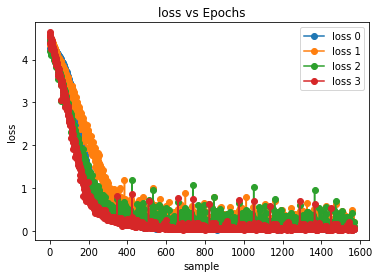

In [22]:
plt.plot(loss_0,'-o')
plt.plot(loss_1,'-o')
plt.plot(loss_2,'-o')
plt.plot(loss_3,'-o')
plt.xlabel('sample')
plt.ylabel('loss')
plt.legend(['loss 0','loss 1','loss 2','loss 3'])
plt.title('loss vs Epochs')

plt.show()

# Accuracy evalutaion F-scores

1. create folder with part object of all pieces 
2. load a piece from dataloader with true labels, the mixed piece and the part object 
3. create notearray from part object
4. take 1 note from notearrray - input -> find corresponding frame by looking at time and pitch


Output: pianoroll

1 note in notearray could be mulitple bins

take 1 note from notearrray - input -> find corresponding frame by looking at time and pitch

note start at same time with different pitch -> different notes

for each note array find corresponding matrix -> 


if note is only composed by 1 bin: save indx of vocie -> save it to note array

if more than 1: look what are idx that compose this note -> majority note -> save it for the note array (if its 50/50 take it random -> count how often this happens) 


with idx : in note_array find which note corresponds to what voice

In [23]:
train_dataset = MusicDataset_new(PATH_TO_DATA) #MusicDataset(PATH_TO_DATA)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

val_dataloader 

In [24]:
## makes cell output nothing
%%capture  
output_dim = 88
model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)  
checkpoint = torch.load("./AI-MA_project/model_temp_epoch5.pkl")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

### Create dic with key:filename, val: part_obj  for fugues

In [25]:
if PATH_TO_DATA == "AI-MA_project/bach_pr_fugues":
    path_parts = "AI-MA_project/bach_fugues"
    part_dic = {}

    #### create a list with all filenames in the right order ####
    file_names_part = []
    for filename in sorted(os.listdir(path_parts)):
        if not filename.endswith('.mid'): continue
        file_names_part.append(filename[3:7])
    #print(file_names_part)

    #### create a list with all part objects in the right order ####
    part_list = []
    for filename in sorted(os.listdir(path_parts)):
        if not filename.endswith('.mid'): continue
        fullname = os.path.join(path_parts, filename)
        part = partitura.load_score_midi(fullname)
        part_list.append(part)
    #print(part_list)

    #### create a dict with keys:filenames , values: part object ####
    for i in range(len(file_names_part)):
        part_dic[file_names_part[i]] = part_list[i]
    
    print(part_dic.keys(),part_dic.values())

### Create dic with key:filename, val: part_obj  for chorales

In [26]:
if PATH_TO_DATA == "AI-MA_project/pianoroll_88":
    path_parts = "AI-MA_project/chorales_converted"
    part_dic = {}

    #### create a list with all filenames in the right order ####
    file_names_part = []
    for filename in sorted(os.listdir(path_parts)):
        if not filename.endswith('.xml'): continue
        file_names_part.append(filename[4:7])
    #print(file_names_part)

    #### create a list with all part objects in the right order ####
    part_list = []
    for filename in sorted(os.listdir(path_parts)):
        if not filename.endswith('.xml'): continue
        fullname = os.path.join(path_parts, filename)
        part = partitura.load_musicxml(fullname)
        part_list.append(part)
    #print(part_list)

    #### create a dict with keys:filenames , values: part object ####
    for i in range(len(file_names_part)):
        part_dic[file_names_part[i]] = part_list[i]
    
    print("part_dic.keys()",part_dic.keys())
    print("part_dic.values()",part_dic.values())

part_dic.keys() dict_keys(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', 

### Evaluate chorales

evaluate chorals

In [61]:
def evaluate_one_choral(model, train_dataloader, part_dic,F1):
    #print("part_dic:",part_dic)

    f_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    note_counter_0 = 0
    note_counter_1 = 0
    note_counter_2 = 0
    note_counter_3 = 0
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
            #check if elements match
                                      
            
            #if idx > 40: # or idx==2:
                if nbr_voices[0]!=len(part_dic[file_name[0]]):
                  print("ERROR: nbr_voices from part DOES NOT MATCH data loader:" ) 
                
                # load correct part object
                file_name = file_name[0]
                part = part_dic[file_name]
                part_0 = part[0]
                note_array_0 = part_0.note_array
                part_1 = part[1]
                note_array_1 = part_1.note_array
                part_2 = part[2]
                note_array_2 = part_2.note_array
                part_3 = part[3]
                note_array_3 = part_3.note_array


                note_counter_0 += len(note_array_0)
                note_counter_1 += len(note_array_1)
                note_counter_2 += len(note_array_2)
                note_counter_3 += len(note_array_3)

                list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]
                
                #print("note_array_0",note_array_0)
                   
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
                accordance_dict = {'0': [], '1': [], '2': [], '3': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    #print("note_array[onset_beat]:",note_array["onset_beat"])
                    
                    #### get only indices that are positive

                    onset_beat = note_array["onset_beat"][note_array["onset_beat"]>=0]

                    #print("new onset", onset_beat)
                    duration_beat = note_array["duration_beat"][note_array["onset_beat"]>=0]
                    pitch_list = note_array["pitch"][note_array["onset_beat"]>=0]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)

                    #print("note_idx_end:",note_idx_end)

                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]
                    
                    #print("note_idx_start",note_idx_start)
                    #print("note_idx_end",note_idx_end)
                    #print("pitch_list",pitch_list)
                    

                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        #print("prediction:",prediction)
                        label = ground_truth_label_list[el_note_arr]

                
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]
                        pitch_first = pitch_list[i]
                        pred_list_first = prediction[start_first:end_first,pitch_first]

                        #print("prediction:",pred_list_first)
                        #if pred_list_first.shape == torch.Size([0]):
                        #    print("empty:",i)
                        

                        truth_list = [label for i in range(len(pred_list_first))]

                    
                        result = all(elem == pred_list_first[0] for elem in pred_list_first)
                        # do majority vote if not all predictions are for same voice
                        if result == False:
                            major, major_idx = torch.mode(pred_list_first,0)
                            major = major.numpy().tolist()
                            pred_list_first = [major for i in pred_list_first]
                        
                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)
                        accordance_dict[str(label)].append(0)


                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                    counting = 0
                    ### maybe insert if statement: if list_of_note_arrays == 4 oder sowas 
                    for j in range(len(total_predictions_dict[i])):
                        #print("total_predictions_dict[i][j]:",total_predictions_dict[i][j] )
                        #print(i,j)
                        #if total_predictions_dict[i][j].shape == torch.Size([0]):
                            #print("fail indices:",i,j)

                        if total_predictions_dict[i][j][0] == gt:
                            counting +=1  
                    count_dict_2[i].append(counting)

                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])

                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                print("acc 2, sample {}:".format(idx),acc_2)
                print("acc 3, sample {}:".format(idx),acc_3)

                
                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                acc_score_dict["2"].append(acc_2)
                acc_score_dict["3"].append(acc_3)



    print("note counters:","v0:",note_counter_0,"v1:",note_counter_1,"v2:",note_counter_2,"v3:",note_counter_3)
    print("total_predictions_dict",total_predictions_dict.keys())
    return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])


In [62]:
a = np.array([-1,-2,1,2,3])
c = np.array([5,6,7,8,9])

a[a>0], c[a>0]

(array([1, 2, 3]), array([7, 8, 9]))

In [63]:
dict_pred , dict_gt, acc_0 , acc_1, acc_2, acc_3 = evaluate_one_choral(model,val_dataloader,part_dic,F1=False)
acc_0 , acc_1, acc_2, acc_3

acc 0, sample 0: 0.9758064516129032
acc 1, sample 0: 0.9512195121951219
acc 2, sample 0: 0.963302752293578
acc 3, sample 0: 1.0
acc 0, sample 1: 0.09859154929577464
acc 1, sample 1: 0.20967741935483872
acc 2, sample 1: 0.2413793103448276
acc 3, sample 1: 0.23728813559322035
acc 0, sample 2: 0.09803921568627451
acc 1, sample 2: 0.23404255319148937
acc 2, sample 2: 0.3
acc 3, sample 2: 0.23809523809523808
acc 0, sample 3: 0.0851063829787234
acc 1, sample 3: 0.22916666666666666
acc 2, sample 3: 0.2222222222222222
acc 3, sample 3: 0.05084745762711865
acc 0, sample 4: 0.04878048780487805
acc 1, sample 4: 0.2631578947368421
acc 2, sample 4: 0.225
acc 3, sample 4: 0.3548387096774194
acc 0, sample 5: 0.056179775280898875
acc 1, sample 5: 0.18604651162790697
acc 2, sample 5: 0.18604651162790697
acc 3, sample 5: 0.2222222222222222
acc 0, sample 6: 0.0660377358490566
acc 1, sample 6: 0.14018691588785046
acc 2, sample 6: 0.23
acc 3, sample 6: 0.20454545454545456
acc 0, sample 7: 0.0714285714285714

(0.3906675883788661,
 0.4704326420186091,
 0.49408811197202057,
 0.467459449004522)

In [ ]:
def evaluate_accuracy_for_chorals(model, train_dataloader, part_dic,F1):
    #print("part_dic:",part_dic)

    f_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    note_counter_0 = 0
    note_counter_1 = 0
    note_counter_2 = 0
    note_counter_3 = 0
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
            #check if elements match
                                      
            
            if idx != 1: # or idx==2:
                if nbr_voices[0]!=len(part_dic[file_name[0]]):
                  print("ERROR: nbr_voices from part DOES NOT MATCH data loader:" ) 
                
                # load correct part object
                file_name = file_name[0]
                part = part_dic[file_name]
                part_0 = part[0]
                note_array_0 = part_0.note_array
                part_1 = part[1]
                note_array_1 = part_1.note_array
                part_2 = part[2]
                note_array_2 = part_2.note_array
                part_3 = part[3]
                note_array_3 = part_3.note_array

                note_counter_0 += len(note_array_0)
                note_counter_1 += len(note_array_1)
                note_counter_2 += len(note_array_2)
                note_counter_3 += len(note_array_3)

                list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]

                   
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
                accordance_dict = {'0': [], '1': [], '2': [], '3': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)

                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]

                
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]
                        pitch_first = pitch_list[i]
                        pred_list_first = prediction[start_first:end_first,pitch_first]

                        #print("prediction:",pred_list_first)
                        


                        truth_list = [label for i in range(len(pred_list_first))]

                    
                        result = all(elem == pred_list_first[0] for elem in pred_list_first)
                        # do majority vote if not all predictions are for same voice
                        if result == False:
                            major, major_idx = torch.mode(pred_list_first,0)
                            major = major.numpy().tolist()
                            pred_list_first = [major for i in pred_list_first]
                        
                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)
                        accordance_dict[str(label)].append(0)


                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                    counting = 0
                    ### maybe insert if statement: if list_of_note_arrays == 4 oder sowas 
                    for j in range(len(total_predictions_dict[i])):
                        #print("total_predictions_dict[i][j]:",total_predictions_dict[i][j] )
                        if total_predictions_dict[i][j][0] == gt:
                            counting +=1  
                    count_dict_2[i].append(counting)

                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])

                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                print("acc 2, sample {}:".format(idx),acc_2)
                print("acc 3, sample {}:".format(idx),acc_3)

                
                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                acc_score_dict["2"].append(acc_2)
                acc_score_dict["3"].append(acc_3)


    print("note counters:","v0:",note_counter_0,"v1:",note_counter_1,"v2:",note_counter_2,"v3:",note_counter_3)
    print("total_predictions_dict",total_predictions_dict.keys())
    return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])
    #return total_predictions_dict, total_truth_dict

In [ ]:
dict_pred , dict_gt, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_for_chorals(model,val_dataloader,part_dic,F1=False)
acc_0 , acc_1, acc_2, acc_3

### evaluate fugues

In [ ]:
from sklearn.metrics import f1_score
import statistics


def evaluate_accuracy_for_all(model, train_dataloader, part_dic,F1):
    #print("part_dic:",part_dic)

    f_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    note_counter_0 = 0
    note_counter_1 = 0
    note_counter_2 = 0
    note_counter_3 = 0
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
            #check if elements match
                                      
            
            #if idx == 0 or idx==2:
                if nbr_voices[0]!=len(part_dic[file_name[0]]):
                  print("ERROR: nbr_voices from part DOES NOT MATCH data loader:" ) 
                
                # load correct part object
                file_name = file_name[0]
                part = part_dic[file_name]
                part_0 = part[0]
                note_array_0 = part_0.note_array
                part_1 = part[1]
                note_array_1 = part_1.note_array
                part_2 = part[2]
                note_array_2 = part_2.note_array

                note_counter_0 += len(note_array_0)
                note_counter_1 += len(note_array_1)
                note_counter_2 += len(note_array_2)

                list_of_note_arrays = [note_array_0,note_array_1,note_array_2]

                if len(part)== 4:
                    part_3 = part[3]
                    note_array_3 = part_3.note_array
                    note_counter_3 += len(note_array_3)
                    list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]

                   
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
                accordance_dict = {'0': [], '1': [], '2': [], '3': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)

                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]

                
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]
                        pitch_first = pitch_list[i]
                        pred_list_first = prediction[start_first:end_first,pitch_first]
                        
                        if i < len(note_idx_start)-1:
                            start_second = note_idx_start[i+1]
                            end_second =  note_idx_end[i+1]
                            pitch_second = pitch_list[i+1]
                            pred_list_second = prediction[start_second:end_second,pitch_second]


                        truth_list = [label for i in range(len(pred_list_first))]

                    
                        result = all(elem == pred_list_first[0] for elem in pred_list_first)
                        # do majority vote if not all predictions are for same voice
                        if result == False:
                            major, major_idx = torch.mode(pred_list_first,0)
                            major = major.numpy().tolist()
                            pred_list_first = [major for i in pred_list_first]

                        result_second = all(elem == pred_list_second[0] for elem in pred_list_second)
                        # do majority vote if not all predictions are for same voice
                        if result_second == False:
                            major_, major_idx = torch.mode(pred_list_second,0)
                            major_ = major_.numpy().tolist()
                            pred_list_second = [major_ for i in pred_list_second]
                        
                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)

                            
                        if F1 == True:
                            if pred_list_first[0] == pred_list_second[0]:   #the list might have diff lenghts as diff notes have diff lengths, so is ito oke to just take first elemet
                                accordance_dict[str(label)].append(1)
                            else:
                                accordance_dict[str(label)].append(0)

                if F1 == False:
                    count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }
                    print("total_predictions_dict.keys())",total_predictions_dict.keys())

                    for gt, i in enumerate(total_predictions_dict.keys()):
                      counting = 0
                      ### maybe insert if statement: if list_of_note_arrays == 4 oder sowas 
                      for j in range(len(total_predictions_dict[i])):
                          if total_predictions_dict[i][j][0] == gt:
                            counting +=1  
                      count_dict_2[i].append(counting)

                    acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                    acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                    acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])

                    print("acc 0, sample {}:".format(idx),acc_0)
                    print("acc 1, sample {}:".format(idx),acc_1)
                    print("acc 2, sample {}:".format(idx),acc_2)

                    if len(list_of_note_arrays)==4:
                        acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                        print("acc 3, sample {}:".format(idx),acc_3)
                        acc_score_dict["3"].append(acc_3)


                    acc_score_dict["0"].append(acc_0)
                    acc_score_dict["1"].append(acc_1)
                    acc_score_dict["2"].append(acc_2)

                if F1 == True:
                    pred_0 = accordance_dict["0"]
                    pred_1 = accordance_dict["1"]
                    pred_2 = accordance_dict["2"]                   
                    truth_0 = [1 for i in range(len(accordance_dict["0"]))]
                    truth_1 = [1 for i in range(len(accordance_dict["1"]))]
                    truth_2 = [1 for i in range(len(accordance_dict["2"]))]                  
                    f1_v0 = sklearn.metrics.f1_score(truth_0, pred_0)
                    f1_v1 = sklearn.metrics.f1_score(truth_1, pred_1)
                    f1_v2 = sklearn.metrics.f1_score(truth_2, pred_2)                
                    f_score_dict["0"].append(f1_v0)
                    f_score_dict["1"].append(f1_v1)
                    f_score_dict["2"].append(f1_v2)
                    if len(part)==4:
                      pred_3 = accordance_dict["3"]
                      truth_3 = [1 for i in range(len(accordance_dict["3"]))]
                      f1_v3 = sklearn.metrics.f1_score(truth_3, pred_3)
                      f_score_dict["3"].append(f1_v3)
    
    if F1 == True:
        return statistics.mean(f_score_dict["0"]), statistics.mean(f_score_dict["1"]), statistics.mean(f_score_dict["2"]),statistics.mean(f_score_dict["3"])
    
    if F1 == False:
        print("note counters:","v0:",note_counter_0,"v1:",note_counter_1,"v2:",note_counter_2,"v3:",note_counter_3)
        print("total_predictions_dict",total_predictions_dict.keys())
        return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])
        #return total_predictions_dict, total_truth_dict

In [ ]:
dict_pred , dict_gt, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_for_all(model,val_dataloader,part_dic,F1=False)
acc_0 , acc_1, acc_2, acc_3

In [ ]:
# 30 epoch, no loss modifier:
#ACC:(0.9165209182020722,
# 0.7864434689151618,
# 0.8130949796045199,
# 0.003652274754166715)

# 20 epoch, no loss modifier:
#(0.7962210840410273, 0.8669639629052727, 0.751302181991106, 0.0)

# 20 ep, loss3 *1,5
#(0.8721136343927623,
 0.8319586824413445,
 0.7563218924966578,
 0.09029535181592076)

In [ ]:
#acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_for_all(model,train_dataloader,part_dic,F1=False)
dict_pred , dict_gt, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_for_all(model,val_dataloader,part_dic,F1=False)
acc_0 , acc_1, acc_2, acc_3

### evaluate fugues F1 score

In [ ]:
f1_v0, f1_v1, f1_v2, f1_v3 = evaluate_accuracy_for_all(model,val_dataloader,part_dic,F1=True)
print(f1_v0, f1_v1, f1_v2, f1_v3)

In [ ]:
dict_pred.keys()

In [ ]:
count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

for gt, i in enumerate(dict_pred.keys()):
  counting = 0
  for j in range(len(dict_pred[i])):
      if dict_pred[i][j][0] == gt:
        print(dict_pred[i][j],dict_gt[i][j])
        counting +=1

      
  count_dict_2[i].append(counting)

print(count_dict_2["0"],count_dict_2["1"],count_dict_2["2"],count_dict_2["3"])

if len(dict_pred.keys())==4:
    print("accuracy:",count_dict_2["0"][0]/len(dict_pred["0"]),count_dict_2["1"][0]/len(dict_pred["1"]),count_dict_2["2"][0]/len(dict_pred["2"]),count_dict_2["3"][0]/len(dict_pred["3"]))

if len(dict_pred.keys())==3:
    print("accuracy:",count_dict_2["0"][0]/len(dict_pred["0"]),count_dict_2["1"][0]/len(dict_pred["1"]),count_dict_2["2"][0]/len(dict_pred["2"]))

In [ ]:
### take 0 -> compare to truth of 0,1,2,3 -> overall voice

count_list = []

count_dict = {'0': [], '1': [], '2': [], '3': [] }
truth_dic = {'0': 0, '1': 1, '2': 2, '3': 3 }

voice_entry_list = ["0", "1", "2", "3"]
for voice_entry_one in voice_entry_list:
    for voice_entry_two in voice_entry_list:
        count_list = []
        #print("voices:",voice_entry_one,voice_entry_two)
        for i in range(len(dict_pred[voice_entry_one])):
            if dict_pred[voice_entry_one][i][0] == truth_dic[voice_entry_two]:      #dict_truth[voice_entry_two][i][0]:
                count_list.append(1)
            else:
                count_list.append(0)
        count_dict[voice_entry_one].append(count_list)

dictionary_sum={}
for i in voice_entry_list:
    v0_match,v1_match,v2_match,v3_match = count_dict[i]
    sum_v0 = np.sum(v0_match)
    sum_v1 = np.sum(v1_match)
    sum_v2 = np.sum(v2_match)
    sum_v3 = np.sum(v3_match)
    dictionary_sum["v0"] = sum_v0
    dictionary_sum["v1"] = sum_v1
    dictionary_sum["v2"] = sum_v2
    dictionary_sum["v3"] = sum_v3

    val_list = list(dictionary_sum.values())
    
    print("voice{} matches with".format(i))
    print("dict",dictionary_sum)

    max_sum = max(sum_v0,sum_v1,sum_v2,sum_v3)


    print("max_sum", val_list.index(max_sum) )

    print("accuracy voice{}:".format(i), max_sum/(sum_v0+sum_v1+sum_v2+sum_v3) )
    print("________________")
    print(" ")

In [ ]:
# FOR MONOPHONIC F1

# start with GT
# look at first note in pred-> save note label
# look at second note in pred-> if same note as before : SUCESS if it is not: FAIL
 # DO This for all 4 voices
 ## in GT there is always the same voice following -> would always be an array of 1

## POLYPHONIC 

# prbl after 1 note there can be multiple diff voices .. chords




you have the ground truth on the different parts that you get when you import your score. Each part correspond to a voice. So if your note array contains all notes of all voices, you have for each note in your note array a number that is the ground truth voice (that you take from the part) and a number that is the predicted voice (that you take from the maximum vote).

start time, duration , pitch to separate 

use the onset_beat and duration_beat

multiply them according to the values set when producing the pianorolls 

-> get the position in the pianoroll

time_div = 12



# Visualization

In [ ]:
plt.plot(his["val_accuracy_v0"],'-o')
plt.plot(his["val_accuracy_v1"],'-o')
plt.plot(his["val_accuracy_v2"],'-o')
plt.plot(his["val_accuracy_v3"],'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Accuracy0','Accuracy1','Accuracy2','Accuracy3'])
plt.title('Accuracy vs Epochs')

plt.show()

In [ ]:
plt.plot(his["val_accuracy"],'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend('Accuracy')
plt.title('Accuracy vs Epochs')

plt.show()

In [ ]:
plt.plot(his["train_loss"],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss'])
plt.title('Loss vs Epochs')

plt.show()

# Old training loop - matrix and non matrix format

def training_loop(model,optimizer, train_dataloader, monophonic, epochs=50, val_dataloader=None, device=None, scheduler=None):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    print("monophonic set to:",monophonic)
    model = model.to(device)
    history = defaultdict(list)

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0
        #accuracy_v0_sum = 0
        #accuracy_v1_sum = 0
        #accuracy_v2_sum = 0
        #accuracy_v3_sum = 0

        accuracy_sum_list = [0 for i in range(5)]                               ########## FIXED FOR 5 voices MAX right now - b.c. FUGUES have max 5 voices
        val_accuracy_sum_list = [0 for i in range(5)]                               ########## FIXED FOR 5 voices MAX right now - b.c. FUGUES have max 5 voices

        accuracy_v_all_sum = 0
        model.train()
        accuracy_sum = 0
        

        for idx, (voices, lens, nbr_voices) in enumerate(train_dataloader):  
            
            voices = voices.to(device).float()
            optimizer.zero_grad()
            loss = model.forward(voices, lens, nbr_voices)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()    

            if monophonic == False:
                with torch.no_grad():
                    prediction = model.predict(voices[:,:,:,-1], lens, monophonic)                      

                    v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
                    mask_pred = (prediction.sum(axis=0) == 0)
                    v_pred_argm[mask_pred] = -1
                    v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)

                    
                    single_voices = voices[:,:,:,:-1]

                    v_ori_argm = torch.argmax(np.squeeze(single_voices,axis=0).cpu(),axis=2)
                    mask_ori = ((np.squeeze(single_voices,axis=0).cpu()).sum(axis=2) == 0).numpy()
                    v_ori_argm[mask_ori] = -1
                    v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                    acc = accuracy_score(v_pred_flat,v_ori_flat)  
                    accuracy_sum += acc 

                    """
                    if nbr_voices == 4: 
                        v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2), torch.tensor(pred_v3)], dim=2)
                    if nbr_voices ==3:
                        v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2)], dim=2)
                    v_pred_argm = v_pred_comb.argmax(dim=2)
                    mask_pred = (v_pred_comb.sum(axis=2) == 0).numpy()
                    v_pred_argm[mask_pred] = -1
                    v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)
                    print("v_pred_flat:", v_pred_flat.shape)
                    """
                    """
                    if nbr_voices == 4:                   
                        v_ori_comb = torch.stack([np.squeeze(voices[:,:,:,0]).cpu(), np.squeeze(voices[:,:,:,1]).cpu(), np.squeeze(voices[:,:,:,2]).cpu(), np.squeeze(voices[:,:,:,3]).cpu()], dim=2)
                    if nbr_voices ==3:
                        v_ori_comb = torch.stack([np.squeeze(voices[:,:,:,0]).cpu(), np.squeeze(voices[:,:,:,1]).cpu(), np.squeeze(voices[:,:,:,2]).cpu()], dim=2)
                    v_ori_argm = v_ori_comb.argmax(dim=2)
                    mask_ori = (v_ori_comb.sum(axis=2) == 0).numpy()
                    print("old mask", mask_ori.shape)
                    v_ori_argm[mask_ori] = -1
                    v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                    print("v_ori_flat", v_ori_flat.shape)
                    acc = accuracy_score(v_pred_flat,v_ori_flat)   
                    print("acc",acc)                    
                    accuracy_sum += acc 
                    """


            if monophonic == True:
                with torch.no_grad():

                    prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                    prediction = torch.swapaxes(torch.tensor(prediction), 0, 1)

                    truth = np.squeeze(voices[:,:,:,:-1]).argmax(dim=1).cpu()

                    acc_list = [0 for i in range(len(prediction[0,:]))]

                    for i in range(len(prediction[0,:])):
                      acc_list[i] = accuracy_score(prediction[:,i], truth[:,i])
                      accuracy_sum_list[i] += acc_list[i]/len(lens)

                    
                    """
                    pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(voices[:,:,:,-1], lens,monophonic)

                    acc_v0 = accuracy_score(torch.tensor(pred_v0), np.squeeze(voices[:,:,:,0]).argmax(dim=1).cpu())
                    acc_v1 = accuracy_score(torch.tensor(pred_v1), np.squeeze(voices[:,:,:,1]).argmax(dim=1).cpu())
                    acc_v2 = accuracy_score(torch.tensor(pred_v2), np.squeeze(voices[:,:,:,2]).argmax(dim=1).cpu())
                    if nbr_voices == 4:
                        acc_v3 = accuracy_score(torch.tensor(pred_v3), np.squeeze(voices[:,:,:,3]).argmax(dim=1).cpu())
                    
                    # normalize according to the number of sequences in the batch (atm len(lens)==1)
                    accuracy_v0_sum += acc_v0 / len(lens)
                    accuracy_v1_sum += acc_v1 / len(lens)
                    accuracy_v2_sum += acc_v2 / len(lens)
                    if nbr_voices == 4:
                        accuracy_v3_sum += acc_v3 / len(lens)
                    """



        train_loss = loss_sum / len(train_dataloader)

        # normalize according to the number of batches
        if monophonic == True:

            train_acc_list = np.array(accuracy_sum_list) / len(train_dataloader)
            train_acc_list[3] = accuracy_sum_list[3] / 18                       ## bc only 18 pieces with len 3
            train_acc_list[4] = accuracy_sum_list[4] / 2                         ##### CHECK IF 2 or 3 pieces with len 4


            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc_list)
            print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}, Train Accuracy_3 : {}, Train Accuracy_4 : {}".format(train_loss, train_acc_list[0], train_acc_list[1], train_acc_list[2], train_acc_list[3],train_acc_list[4])) 


            """
            train_accuracy_v0 = accuracy_v0_sum / len(train_dataloader)
            train_accuracy_v1 = accuracy_v1_sum / len(train_dataloader)
            train_accuracy_v2 = accuracy_v2_sum / len(train_dataloader)
            train_accuracy_v3 = accuracy_v3_sum / 18   ## bc only 18 pieces with len 3

            history["train_loss"].append(train_loss)
            history["train_accuracy_v0"].append(train_accuracy_v0)
            history["train_accuracy_v1"].append(train_accuracy_v1)
            history["train_accuracy_v2"].append(train_accuracy_v2)
            #if nbr_voices == 4:
            history["train_accuracy_v3"].append(train_accuracy_v3)
            print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}, Train Accuracy_3 : {}".format(train_loss, train_accuracy_v0, train_accuracy_v1, train_accuracy_v2, train_accuracy_v3)) 
            #else:
            #    print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}".format(train_loss, train_accuracy_v0, train_accuracy_v1, train_accuracy_v2)) 
            """

        if monophonic == False:
            train_accuracy = accuracy_sum / len(train_dataloader)

            history["train_loss"].append(train_loss)
            history["train_accuracy"].append(train_accuracy)
            print("Train Loss: {}, Train Accuracy : {}".format(train_loss, train_accuracy)) 


        if monophonic == True:
            if val_dataloader is not None:
                # Evaluate on the validation set
                model.eval()
                accuracy_v0_sum = 0
                accuracy_v1_sum = 0
                accuracy_v2_sum = 0
                accuracy_v3_sum = 0

                with torch.no_grad():

                    for voices, lens, nbr_voices in val_dataloader:

                        voices = voices.to(device).float()

                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        prediction = torch.swapaxes(torch.tensor(prediction), 0, 1)

                        truth = np.squeeze(voices[:,:,:,:-1]).argmax(dim=1).cpu()

                        acc_list = [0 for i in range(len(prediction[0,:]))]

                        for i in range(len(prediction[0,:])):
                          acc_list[i] = accuracy_score(prediction[:,i], truth[:,i])
                          val_accuracy_sum_list[i] += acc_list[i]/len(lens)


                        #print("val_accuracy_sum_list[3]",val_accuracy_sum_list[3])
                    #val_acc_list = np.array(val_accuracy_sum_list) / len(train_dataloader)
                    #val_acc_list[3] = val_acc_list[3] / 18                       ## bc only 18 pieces with len 3
                    #val_acc_list[4] = val_acc_list[4] / 2                         ##### CHECK IF 2 or 3 pieces with len 4


                #history["val_acc_new"].append(val_acc_list)
                #print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}, Validation Accuracy_3 : {}, Validation Accuracy_4 : {}".format(val_acc_list[0], val_acc_list[1], val_acc_list[2], val_acc_list[3],val_acc_list[4]))



                        # Predict the model's output on a batch
                        pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(voices[:,:,:,-1], lens,monophonic)
                            
                        # compute the accuracy 
                        acc_v0 = accuracy_score(torch.tensor(pred_v0), np.squeeze(voices[:,:,:,0]).argmax(dim=1).cpu())
                        acc_v1 = accuracy_score(torch.tensor(pred_v1), np.squeeze(voices[:,:,:,1]).argmax(dim=1).cpu())
                        acc_v2 = accuracy_score(torch.tensor(pred_v2), np.squeeze(voices[:,:,:,2]).argmax(dim=1).cpu())
                        if nbr_voices == 4:
                            acc_v3 = accuracy_score(torch.tensor(pred_v3), np.squeeze(voices[:,:,:,3]).argmax(dim=1).cpu())
                            
                            
                        # normalize according to the number of sequences in the batch (atm len(lens)==1)
                        accuracy_v0_sum += acc_v0 / len(lens)
                        accuracy_v1_sum += acc_v1 / len(lens)
                        accuracy_v2_sum += acc_v2 / len(lens)
                        if nbr_voices == 4:
                            accuracy_v3_sum += acc_v3 / len(lens)

                    # normalize according to the number of batches
                    val_accuracy_v0 = accuracy_v0_sum / len(val_dataloader)
                    val_accuracy_v1 = accuracy_v1_sum / len(val_dataloader)
                    val_accuracy_v2 = accuracy_v2_sum / len(val_dataloader)
                    val_accuracy_v3 = accuracy_v3_sum / 18  ##len(val_dataloader). - bc 18 pieces only with voice 3


                    val_acc_list = np.array(val_accuracy_sum_list) / len(val_dataloader)
                    val_acc_list[3] = val_accuracy_sum_list[3] / 18                       ## bc only 18 pieces with len 3
                    val_acc_list[4] = val_accuracy_sum_list[4] / 2                         ##### CHECK IF 2 or 3 pieces with len 4
                    


                history["val_accuracy_v0"].append(val_accuracy_v0)
                history["val_accuracy_v1"].append(val_accuracy_v1)
                history["val_accuracy_v2"].append(val_accuracy_v2)
                #if nbr_voices == 4:
                history["val_accuracy_v3"].append(val_accuracy_v3)
                print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}, Validation Accuracy_3 : {}".format(val_accuracy_v0, val_accuracy_v1, val_accuracy_v2, val_accuracy_v3))
                #else:
                #    print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}".format(val_accuracy_v0, val_accuracy_v1, val_accuracy_v2))


                history["val_acc_new"].append(val_acc_list)
                print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}, Validation Accuracy_3 : {}, Validation Accuracy_4 : {}".format(val_acc_list[0], val_acc_list[1], val_acc_list[2], val_acc_list[3],val_acc_list[4]))


        if monophonic == False:
            if val_dataloader is not None:
                # Evaluate on the validation set
                model.eval()
                accuracy_sum = 0
                
                with torch.no_grad():
                    for voices, lens, nbr_voices in val_dataloader:

                        voices = voices.to(device).float()
                        
                        # Predict the model's output on a batch

                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)                      

                        v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
                        mask_pred = (prediction.sum(axis=0) == 0)
                        v_pred_argm[mask_pred] = -1
                        v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)
                        
                        single_voices = voices[:,:,:,:-1]

                        v_ori_argm = torch.argmax(np.squeeze(single_voices,axis=0).cpu(),axis=2)
                        mask_ori = ((np.squeeze(single_voices,axis=0).cpu()).sum(axis=2) == 0).numpy()
                        v_ori_argm[mask_ori] = -1
                        v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                        acc = accuracy_score(v_pred_flat,v_ori_flat)  
                        accuracy_sum += acc 

                        """
                        pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(voices[:,:,:,-1], lens,monophonic)
                        if nbr_voices == 4: 
                            v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2), torch.tensor(pred_v3)], dim=2)
                        if nbr_voices ==3:
                            v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2)], dim=2)
                        v_pred_argm = v_pred_comb.argmax(dim=2)
                        mask_pred = (v_pred_comb.sum(axis=2) == 0).numpy()
                        v_pred_argm[mask_pred] = -1
                        v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)                      
                        if nbr_voices == 4:                   
                            v_ori_comb = torch.stack([np.squeeze(voices[:,:,:,0]).cpu(), np.squeeze(voices[:,:,:,1]).cpu(), np.squeeze(voices[:,:,:,2]).cpu(), np.squeeze(voices[:,:,:,3]).cpu()], dim=2)
                        if nbr_voices ==3:
                            v_ori_comb = torch.stack([np.squeeze(voices[:,:,:,0]).cpu(), np.squeeze(voices[:,:,:,1]).cpu(), np.squeeze(voices[:,:,:,2]).cpu()], dim=2)
                        v_ori_argm = v_ori_comb.argmax(dim=2)
                        mask_ori = (v_ori_comb.sum(axis=2) == 0).numpy()
                        v_ori_argm[mask_ori] = -1
                        v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)

                        acc = accuracy_score(v_pred_flat,v_ori_flat)
                        accuracy_sum += acc 
                        """
                        
                    # normalize according to the number of batches
                    val_accuracy = accuracy_sum / len(val_dataloader)

                history["val_accuracy"].append(val_accuracy)  
                print(" Validation Accuracy : {}".format(val_accuracy))


        if scheduler is not None:
            scheduler.step()

        # save the model
        torch.save(model, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history